# Introduction
In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City. There are quite a few EDA kernels and some of them are excellent. Here I try to focus more on the feature extraction. In this Kernel you could find a few general kaggle related tips and a some modeling improvement ideas as well.

**My main goal is to craft the best possible feature set for XGB with the given Kernel limitations.**

My current best submission is still based on this script. My best single model with these features reached LB 0.371. Linear combination of several models gave LB 0.368. Stacking added marginal improvement to 0.367.

Please feel free to fork and use the features and search better parameters.

With this simple notebook we 

 - Explore the dataset
 - Extract 59 useful features
 - Create simple 80-20 train - validation set
 - Train XGBregressor
 - Analyze Feature Importance
 - Score test set and submit
 - Check XGB parameter search result for further improvements

**References**

 - I used a few feature extraction ideas from Nir Malbin's [Kernel](https://www.kaggle.com/donniedarko/darktaxi-tripdurationprediction-lb-0-385)
 - Thanks for oscarleo for this external [dataset](https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm)



In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')


# First week progress

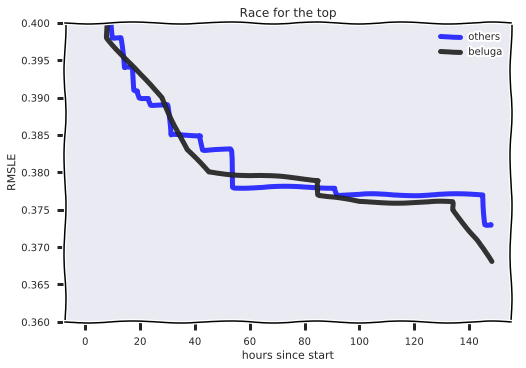

In [2]:
beluga = pd.DataFrame({'since_start_hour': [8.0, 8.0, 20.0, 28.0, 37.0, 45.0, 85.0, 85.0, 100.0, 134.0, 134.0, 143.0, 148.0],
                       'Score': [ 0.400,  0.398,  0.393,  0.390,  0.383,  0.380,  0.379,  0.377,  0.376,  0.376,  0.375,  0.371,  0.368]})
others = pd.DataFrame({'since_start_hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148],
                        'BestScore': [.452,.452,.452,.452,.452,.452,.421,.421,.421,.406,.398,.398,.398,.398,.394,.394,.394,.394,.391,.391,.390,.390,.390,.390,.389,.389,.389,.389,.389,.389,.389,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.373,.373,.373]}) 
with plt.xkcd():
    # This figure will be in XKCD-style
    fig, ax = plt.subplots()
    ax.plot(others.since_start_hour.values, others.BestScore.values, 'b', alpha=0.8, lw=5, label='others')
    ax.plot(beluga.since_start_hour.values, beluga.Score.values, 'k', alpha=0.8, lw=5, label='beluga')
    ax.set_ylim(0.36, 0.4)
    ax.legend(loc=0)
    ax.set_xlabel('hours since start')
    ax.set_ylabel('RMSLE')
    ax.set_title('Race for the top')
    plt.show()

# Data understanding

In [3]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.csv')
sample_submission = pd.read_csv('../input/nyc-taxi-trip-duration/sample_submission.csv')

Let's check the data files! According the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - duration of the trip in seconds

Obviously dropoff_datetime and trip_duration are only available for the train set.

In [4]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [5]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values))== 0 else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'Y', 'N'}.


In [6]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [7]:
train['trip_duration'].max() // 3600

979

We can see that the max trip_duration is ~ 1000 hours. Fortunately the evaluation metric is RMSLE and not RMSE . Outliers will cause less trouble. We could logtransform our target label and use RMSE during training.

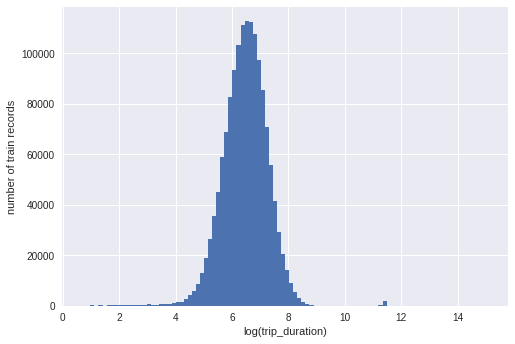

In [8]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

## Validation Strategy
First let's check the train test split. It helps to decide our validation strategy and gives ideas about feature engineering.

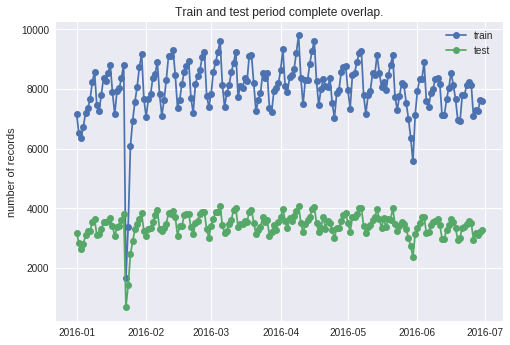

In [9]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

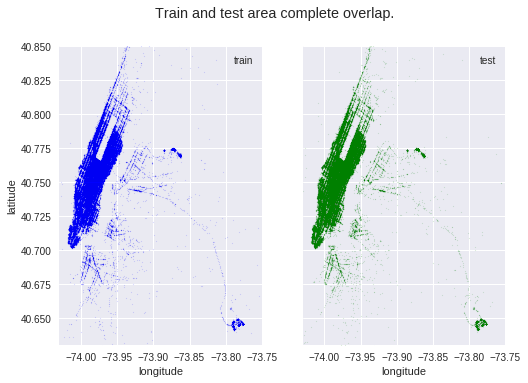

In [10]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In this case the train and test split seems to be random. This allows us to use unsupervised learning and feature extraction to be applied on the full data set.

# Feature Extraction

## PCA
We use PCA to transform longitude and latitude coordinates. In this case it is not about dimension reduction since we transform 2D-> 2D. The rotation could help for decision tree splits.

In [11]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

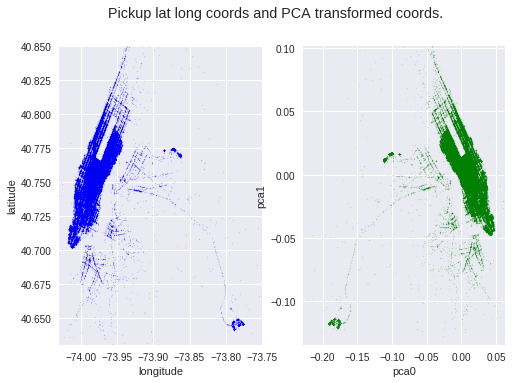

In [12]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

## Distance
Let's calculate the distance (km) between pickup and dropoff points. Currently Haversine is used, geopy has another heuristics (vincenty() or great_circle()) if you prefer.
The cabs are not flying and we are in New York so we could check the Manhattan (L1) distance too :) 

pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays.
We extraxt the middle of the path as a feature as well.

In [13]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

## Datetime features

In [14]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

##Speed

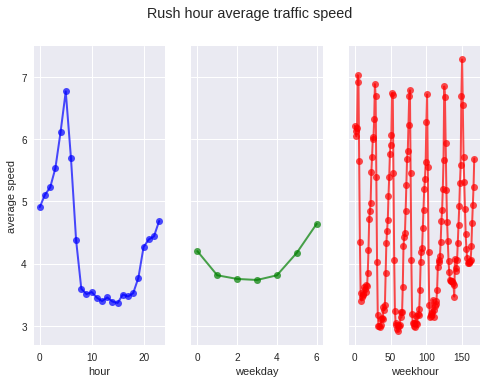

In [15]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

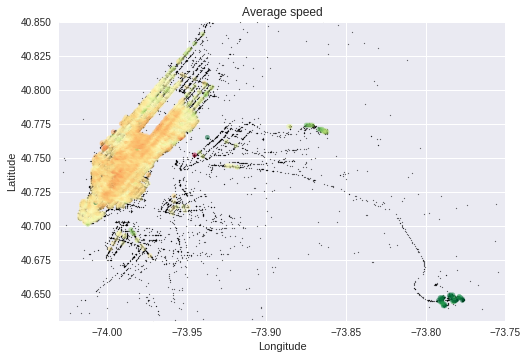

In [16]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

## Clustering

In [17]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [18]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
t1 = dt.datetime.now()
print('Time till clustering: %i seconds' % (t1 - t0).seconds)

Time till clustering: 105 seconds


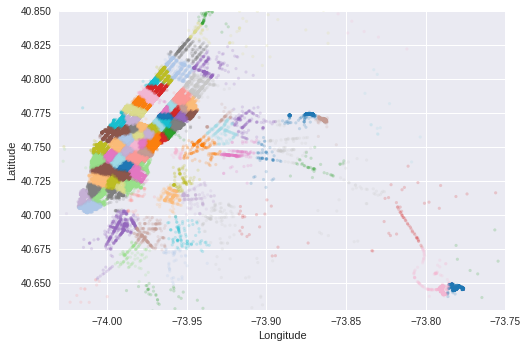

In [19]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

## Temporal and geospatial aggregation
Add a few average traffic speed features. Note that if the train/test split would be time based then we could not use as much temporal features. In this competition we do not need to predict the future.

In [20]:
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [21]:
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

In [22]:
# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

## OSRM Features

We had only rough distance estimates in the previous versions. Now we use better fastest route distance estimates between pickup and dropoff.

In [23]:
fr1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [24]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

t1 = dt.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 59 features.
Feature extraction time: 178 seconds


## Feature check before modeling
It might save you some headache to check your train and test feature distributions before modeling. Usually in kaggle competitions train and test sets are iid. If there is huge differenc between train and test set than probably you have a bug in your feature extraction pipeline.

In [25]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
21,pickup_dt,0.002648
48,cnt_pickup_hour_pickup_cluster,0.002718
7,pickup_pca0,0.002774
10,dropoff_pca1,0.002833
18,pickup_hour_weekofyear,0.002872


In [26]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
26,avg_speed_m_gby_pickup_hour,0.000,0.000,0.000
19,pickup_hour,0.000,0.000,0.000
18,pickup_hour_weekofyear,0.000,0.000,0.000
52,cnt_pickup_cluster_dropoff_cluster,0.105,0.107,0.002
51,avg_speed_h_pickup_cluster_dropoff_cluster,0.105,0.107,0.002


Even the top mean difference is less than 1% of the standard deviation. We have a few missing values but the missing rates are the same. Fortunately xgboost can handle missing values.

# Modeling

In [27]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [28]:
# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.22547	valid-rmse:4.22659
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.40166	valid-rmse:0.416253
[20]	train-rmse:0.370141	valid-rmse:0.390849
[30]	train-rmse:0.360826	valid-rmse:0.387562
[40]	train-rmse:0.355397	valid-rmse:0.38651
[50]	train-rmse:0.351369	valid-rmse:0.385515
[59]	train-rmse:0.348421	valid-rmse:0.385454


In [29]:
print('Modeling RMSLE %.5f' % model.best_score)
t1 = dt.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)

Modeling RMSLE 0.38538
Training time: 272 seconds


## Feature importance analysis

Xgboost models has feature importance score which is often used. Please note that it does not necessary means that the feature is really important, higher score means that the feature was used in more tree splits. Features with strong correlation or with high cardinality bias the result.

I tried a simple backward feature elimination round. For each feature a new model was trained without that feature. It helps to understand what are the essential features which we should not remove. Since it would take a few hours to train 56 models I use my offline validation result.

*Please note the OSRM features were added later so they are not included in the following section. Trust me they are important ;)*

In [30]:
rmse_wo_feature = [0.39224, 0.38816, 0.38726, 0.38780, 0.38773, 0.38792, 0.38753, 0.38745, 0.38710, 0.38767, 0.38738, 0.38750, 0.38678, 0.39359, 0.38672, 0.38794, 0.38694, 0.38750, 0.38742, 0.38673, 0.38754, 0.38705, 0.38736, 0.38741, 0.38764, 0.38730, 0.38676, 0.38696, 0.38750, 0.38705, 0.38746, 0.38727, 0.38750, 0.38771, 0.38747, 0.38907, 0.38719, 0.38756, 0.38701, 0.38734, 0.38782, 0.38673, 0.38797, 0.38720, 0.38709, 0.38704, 0.38809, 0.38768, 0.38798, 0.38849, 0.38690, 0.38753, 0.38721, 0.38807, 0.38830, 0.38750, np.nan, np.nan, np.nan]
feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names, 'rmse_wo_feature': rmse_wo_feature})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

feature_importance[['feature_name', 'importance', 'rmse_wo_feature']].sort_values(by='importance', ascending=False)

,feature_name,importance,rmse_wo_feature
37,avg_speed_h_pickup_cluster_dropoff_cluster,746.0,0.38753
50,pca_manhattan,739.0,0.38672
28,pickup_pca1,734.0,0.38710
49,total_distance,718.0,0.00000
18,pickup_longitude,707.0,0.38726
7,pickup_latitude,707.0,0.38780
3,distance_haversine,673.0,0.38750
51,dropoff_latitude,661.0,0.38792
0,total_travel_time,658.0,0.00000
13,direction,620.0,0.39359


The following plot shows the feature elimination result and the xgboost importance.
A few observations:

 - We had quite a few location related feature with high feature importance score although removing just one of them does not really increase the error.
 - Vendor_id is the second least used feature according to feature importance plot but removing it increases the rmse significantly. It is binary value, even a few decision trees using it captures its information.
 - Direction is important from both aspect. It does not have many correlated feature and removing it would hurt the model.
 - There are lots of different features which could be removed without really breaking a leg.

In real world projects I prefer models with less variables however in kaggle competitions I err on having more even if they only give marginal improvent.

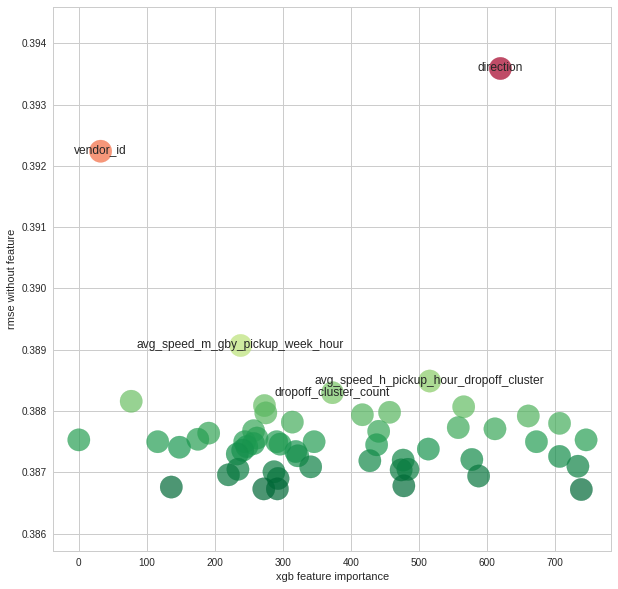

In [31]:
feature_importance = feature_importance.sort_values(by='rmse_wo_feature', ascending=False)
feature_importance = feature_importance[feature_importance['rmse_wo_feature'] > 0]
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(feature_importance['importance'].values, feature_importance['rmse_wo_feature'].values,
               c=feature_importance['rmse_wo_feature'].values, s=500, cmap='RdYlGn_r', alpha=0.7)
    for _, row in feature_importance.head(5).iterrows():
        ax.text(row['importance'], row['rmse_wo_feature'], row['feature_name'],
                verticalalignment='center', horizontalalignment='center')
    ax.set_xlabel('xgb feature importance')
    ax.set_ylabel('rmse without feature')
    ax.set_ylim(np.min(feature_importance['rmse_wo_feature']) - 0.001,
                np.max(feature_importance['rmse_wo_feature']) + 0.001)
    plt.show()

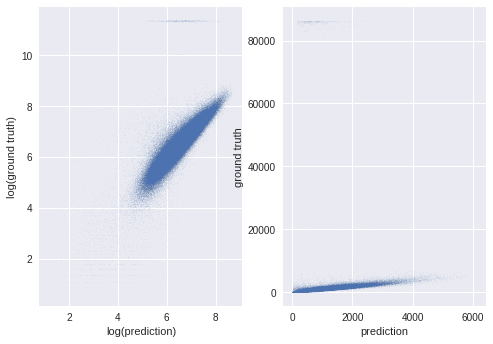

In [32]:
ypred = model.predict(dvalid)
fig,ax = plt.subplots(ncols=2)
ax[0].scatter(ypred, yv, s=0.1, alpha=0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')
ax[1].scatter(np.exp(ypred), np.exp(yv), s=0.1, alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')
plt.show()

# Submission
We need to transform back the log duration and save the submission file. 

Most of the time the five daily submission slots should me more than enough since you could (and should) validate your experiments locally. If you are working in team  or the competition is near to its end then you would like to avoid bugs before submission. Here we check the valid and test prediction distribution. Due to the iid split they should look like the same. Checking correlation with previous submissions could give you more confidence.

Test shape OK.
Valid prediction mean: 6.467
Test prediction mean: 6.467


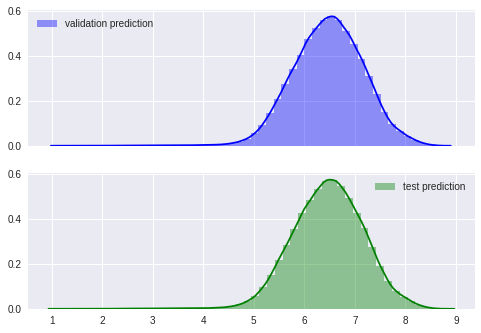

Total time: 284 seconds


In [33]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('beluga_xgb_submission.csv.gz', index=False, compression='gzip')

print('Valid prediction mean: %.3f' % ypred.mean())
print('Test prediction mean: %.3f' % ytest.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = dt.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)

The distributions look like identical. We are ready for submission.

# XGB Parameter Search Result

For parameter tuning I prefer random search.  Usually I try different values for the following parameters

 - min_child_weight
 - eta
 - colsample_bytree
 - max_depth
 - subsample
 - lambda

I like sklearn CV options (RandomizedSearchCV or GridSearchCV) however for usual competitions the training for a single model could take hours and I like to save the intermediate results (performance metric, oof predictions etc.) so I use custom search. Based on the results I like to set the grid searchpoints manually. A simple random parameter search would be

In [34]:
FOREVER_COMPUTING_FLAG = False
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
                                         'colsample_bytree': CS, 'max_depth': MD,
                                         'subsample': SS, 'lambda': LAMBDA, 
                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',
                                         'silent': 1, 'objective': 'reg:linear'})

while FOREVER_COMPUTING_FLAG:
    xgb_par = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.5f' % model.best_score)

These experiments would take much more than the Kernel limitation so a subset of the result is copied here.

In [35]:
paropt = pd.DataFrame({'lambda':[1.5,1.0,1.0,1.5,1.5,1.0,1.5,1.0,1.5,2.0,0.5,1.0,0.5,1.5,1.5,0.5,1.0,1.5,0.5,2.0,1.0,2.0,2.0,1.5,1.5,2.0,1.5,2.0,1.5,0.5,1.0,1.0,2.0,1.5,1.0,1.0,0.5,2.0,1.0,0.5,0.5,2.0,1.0,1.0,0.5,0.5,1.5,0.5,1.5,2.0,2.0,2.0,2.0,0.5,1.5,1.0,1.5,2.0,2.0,0.5,1.5,1.0,0.5,1.0,1.5,2.0,1.0,1.0,2.0,2.0,1.0,0.5,0.5,1.0,1.5,2.0,0.5,1.0,1.5,1.0,1.0,1.5,1.5,1.5,0.5,1.5,1.0,1.5,2.0,2.0,2.0,1.0,2.0,0.5,2.0,0.5,1.5,0.5,2.0,0.5,1.0,1.5,1.5,1.5,2.0,0.5,0.5,1.0,2.0],
                       'eta':[.1,.1,.05,.05,.05,.15,.15,.1,.1,.05,.15,.15,.15,.1,.1,.1,.1,.05,.15,.05,.05,.05,.15,.15,.05,.05,.05,.05,.15,.15,.15,.15,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.1,.1,.05,.05,.15,.15,.15,.1,.1,.05,.05,.05,.05,.05,.15,.1,.1,.15,.1,.1,.05,.15,.15,.15,.1,.05,.05,.05,.05,.15,.1,.1,.1,.1,.05,.05,.05,.15,.15,.1,.1,.1,.1,.05,.15,.15,.1,.1,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.15,.05,.05,.15,.15],
                       'min_child_weight': [50,50,20,100,10,50,100,100,75,10,10,50,50,100,75,100,50,10,20,10,75,20,50,75,100,100,10,20,75,75,75,20,10,75,10,100,100,10,20,20,50,50,100,20,50,100,100,75,20,75,20,50,20,10,20,20,20,75,20,75,100,10,10,20,10,20,100,75,75,10,100,50,100,100,50,10,75,75,50,10,75,75,50,75,20,100,100,50,20,20,50,50,75,20,50,100,75,75,100,75,10,10,20,20,10,10,75,50,20],
                       'subsample':[.8,.9,.8,.6,.6,.6,.9,.6,.5,.9,.8,.9,.7,.5,.5,.9,.7,.7,.5,.8,.5,.9,.6,.6,.8,.8,.8,.7,.5,.5,.9,.9,.5,.6,.7,.8,.8,.6,.9,.7,.8,.6,.6,.9,.7,.7,.8,.6,.6,.5,.9,.8,.7,.6,.6,.6,.5,.9,.8,.5,.7,.6,.8,.6,.8,.8,.6,.7,.9,.5,.7,.5,.9,.7,.8,.9,.9,.7,.8,.5,.7,.8,.6,.8,.8,.5,.9,.5,.5,.7,.8,.6,.6,.8,.7,.6,.6,.6,.7,.7,.8,.6,.5,.9,.7,.6,.9,.5,.5],
                       'rmse': [.380,.380,.377,.378,.378,.386,.382,.382,.383,.374,.386,.381,.385,.383,.383,.379,.381,.376,.389,.375,.381,.374,.385,.385,.378,.377,.375,.376,.385,.386,.382,.384,.384,.379,.376,.380,.380,.382,.380,.382,.378,.385,.384,.383,.383,.383,.379,.381,.386,.387,.381,.380,.380,.377,.377,.377,.379,.376,.382,.385,.382,.386,.380,.382,.375,.383,.385,.384,.379,.378,.380,.381,.378,.384,.380,.377,.379,.383,.380,.380,.380,.383,.385,.381,.379,.386,.380,.383,.387,.383,.382,.384,.385,.377,.380,.383,.383,.383,.382,.382,.377,.386,.388,.382,.384,.379,.378,.387,.388]
                       })

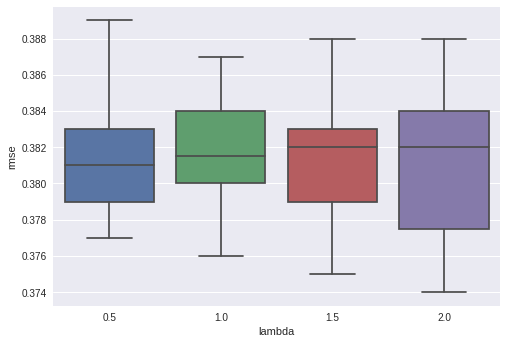

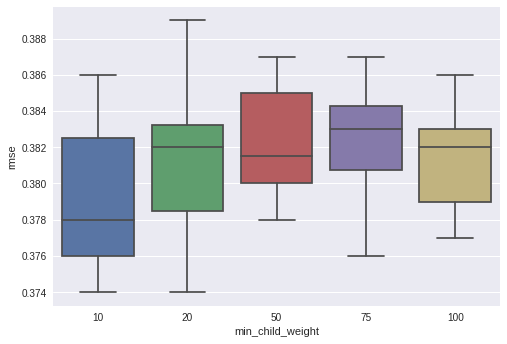

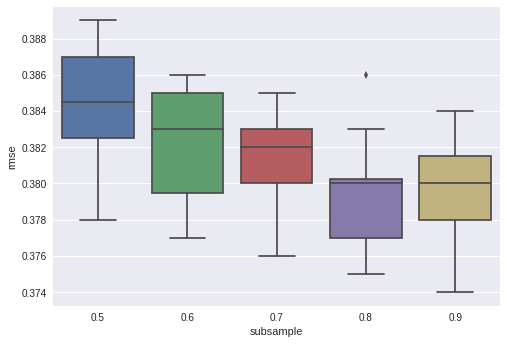

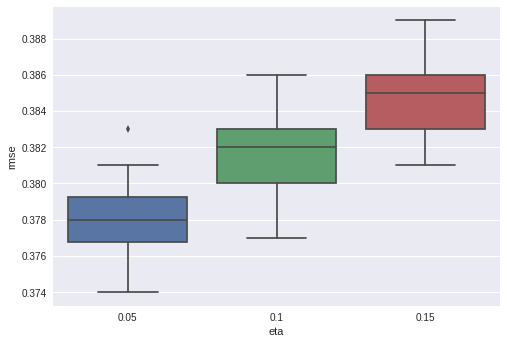

In [36]:
for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
    fig, ax = plt.subplots()
    ax = sns.boxplot(x=par, y="rmse", data=paropt)

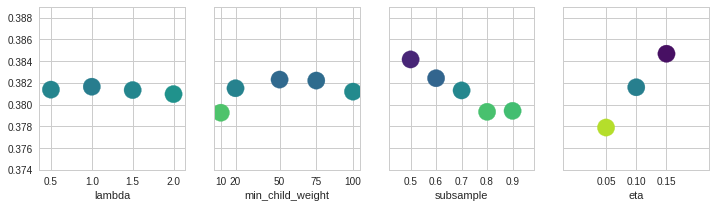

In [37]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(12, 3))
    for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
        mean_rmse = paropt.groupby(par).mean()[['rmse']].reset_index()
        axs[i].scatter(mean_rmse[par].values, mean_rmse['rmse'].values, c=mean_rmse['rmse'].values,
                       s=300, cmap='viridis_r', vmin=.377, vmax=.385, )
        axs[i].set_xlabel(par)
        axs[i].set_xticks(mean_rmse[par].values)
        axs[i].set_ylim(paropt.rmse.min(), paropt.rmse.max())

We can see that lower eta could improve the performance significantly. Higher subsample and smaller child limit leads to better results too. Lambda does not really matter.

# Cross Validation test

We saw lower (better) RMSLE in our train validation than the LB submission. We could check all our submissions.

CV - LB Diff: 0.005


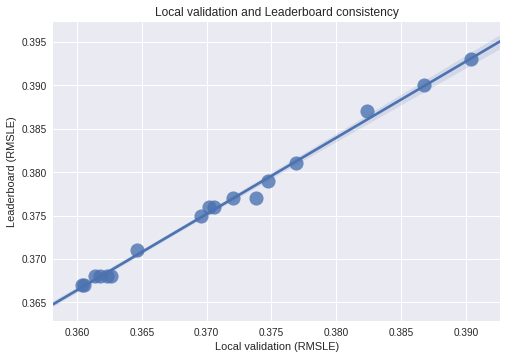

In [38]:
cv_lb = pd.DataFrame({'cv': [0.3604,0.36056,0.3614,0.3618,0.3623,0.3626,0.3646,0.3696,0.3702,0.3706,0.372,0.3738,0.37477,0.37691,0.3824,0.3868,0.3904],
                      'lb': [0.367,0.367,0.368,0.368,0.368,0.368,0.371,0.375,0.376,0.376,0.377,0.377,0.379,0.381,0.387,0.39,0.393]})
ax = sns.regplot(x="cv", y="lb", data=cv_lb, scatter_kws={'s': 200})
ax.set_xlabel('Local validation (RMSLE)')
ax.set_ylabel('Leaderboard (RMSLE)')
ax.set_title('Local validation and Leaderboard consistency')
print('CV - LB Diff: %.3f' % np.mean(cv_lb['lb'] - cv_lb['cv']))

We can see that our local validation scores are usually lower (by ~0.005). Consistent difference is not problem in most kaggle competitions however if the gap starts to increase you should check your training pipeline looking for leaks or cause of overfitting.